<a href="https://colab.research.google.com/github/hyperborean72/netology/blob/ai.lecture-2/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_2.%20%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C%20%D0%B4%D0%BB%D1%8F%20%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F%20%D1%86%D0%B5%D0%BD%D1%8B%20%D0%B4%D0%BE%D0%BC%D0%B0%20-%20%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boston House Prices

В этом ноутбуке мы построим регрессионную модель для предсказания цены дома в тысячях долларов по различным факторам, таким как количество комнат, уровень преступности в районе, число школ и др.

# Подготовка

Импорт необходимых библиотек

In [ ]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Устанавливаем стиль для графиков

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Фиксируем генератор случайных чисел для воспроизводимости эксперимента

In [ ]:
np.random.seed(42)
torch.manual_seed(42);

# Чтение данных

Датасет Boston House Prices очень популярный "начальный" датасет в среде Машинного Обучения. Скачаем, распакуем и посмотрим на таблицу данных

In [ ]:
!wget https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MASS/Boston.csv

--2023-06-20 13:26:52--  https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MASS/Boston.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37658 (37K) [text/plain]
Saving to: ‘Boston.csv’

Boston.csv          100%[===================>]  36.78K  --.-KB/s    in 0.004s  

2023-06-20 13:26:52 (9.36 MB/s) - ‘Boston.csv’ saved [37658/37658]



In [ ]:
df = pd.read_csv('Boston.csv')
df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
y = df['medv']
X = df[['crim', 'zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','black','lstat']]

Пример данных

In [ ]:
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [ ]:
y[:5]

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: medv, dtype: float64

Статистики по данным. Их полезно смотреть, чтобы понять какие признаки мы вообще имеем

In [ ]:
X.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Здесь важно заметить, что в датасете есть признаки очень разного масштаба. Какие-то признаки, например CHAS, имеют значения от 0 до 1, а какие-то, например ZN, от 0 до 100.

Также посмотрим на матрицу корреляций между признаками

<ipython-input-10-ee05582cf8af>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


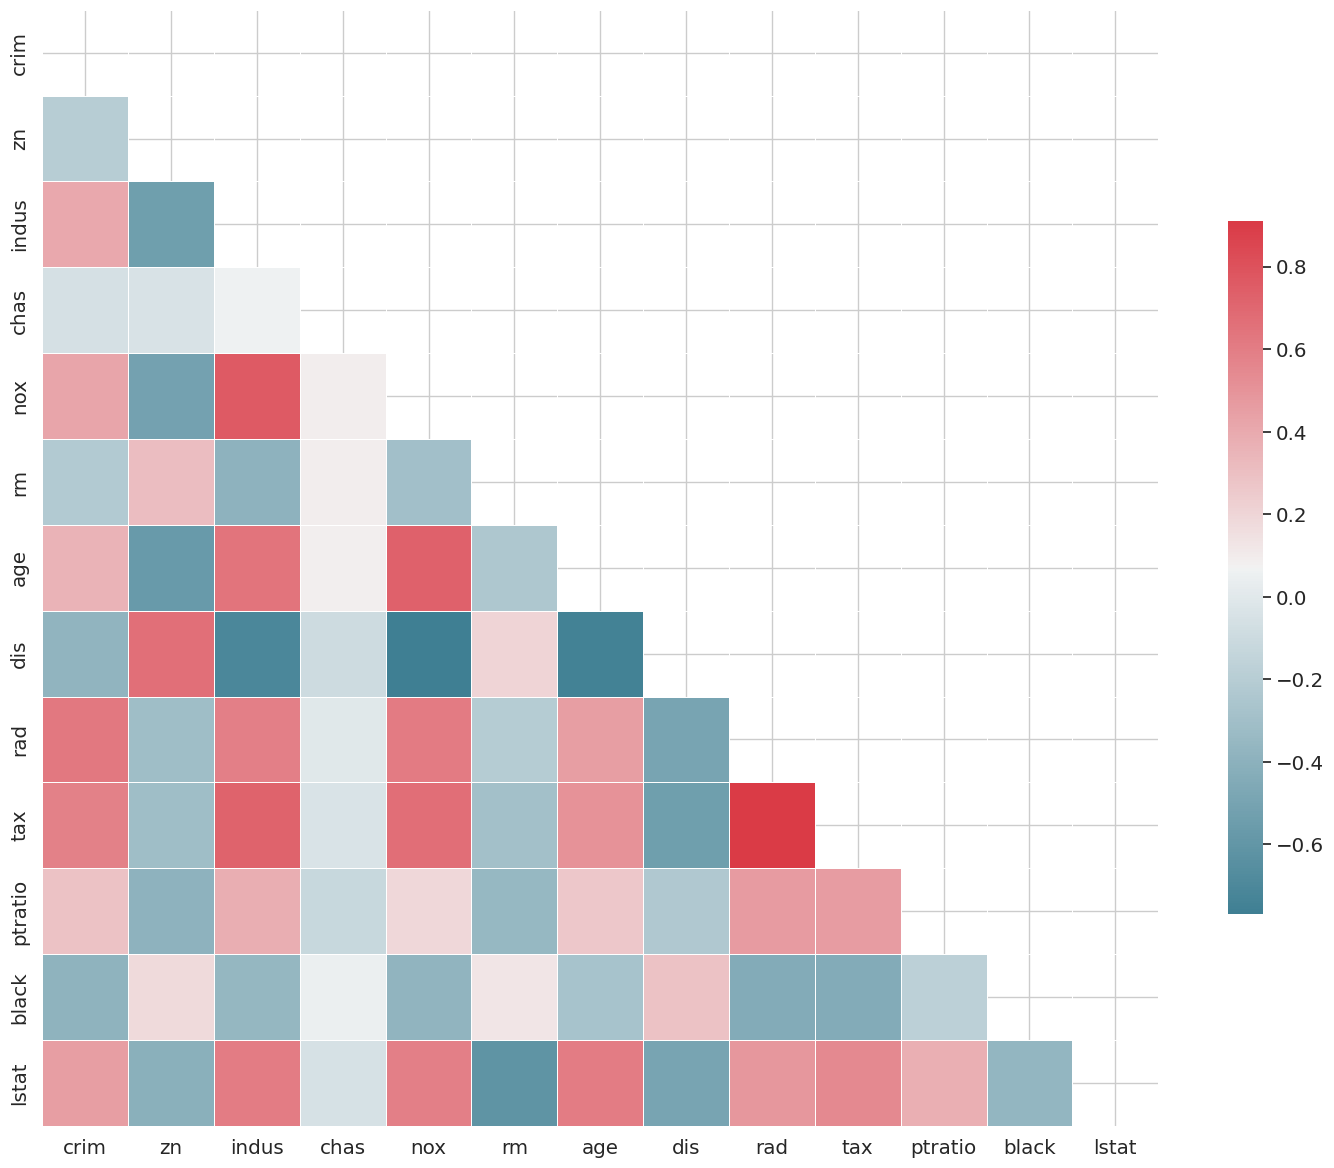

In [ ]:
corr = X.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 18))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

# Предобработка данных

## Разбиение

Разобьем наши данные на обучающую и валидационную выборки в пропорции $\frac{4}{1}$

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

В датасете довольно много признаков, так что давайте визуализируем только некоторые из них

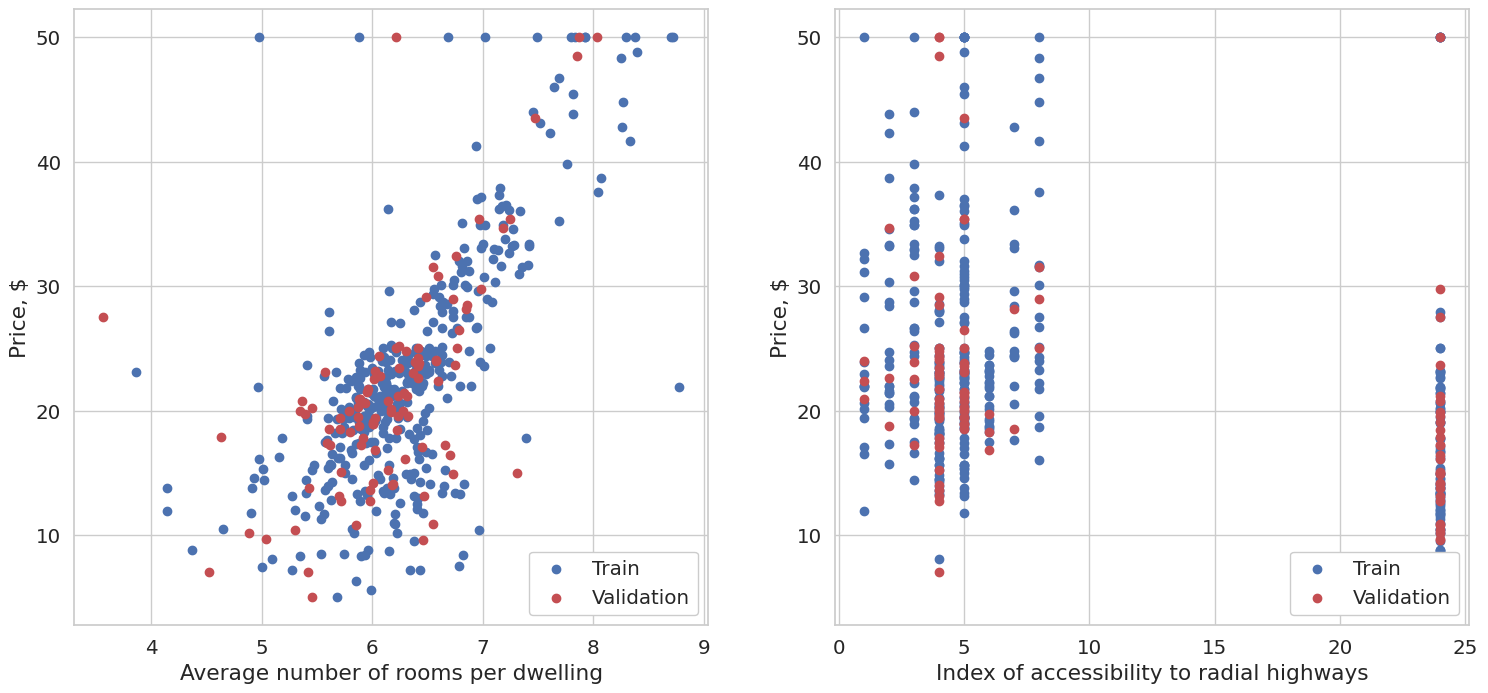

In [ ]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.rm, y_train, label="Train")
plt.scatter(X_val.rm, y_val, c="r", label="Validation")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train.rad, y_train, label="Train")
plt.scatter(X_val.rad, y_val, c="r", label="Validation")
plt.xlabel("Index of accessibility to radial highways")
plt.ylabel("Price, $")
plt.legend(loc="lower right");

## Масштаб

Сделаем нормализацию каждого признака в диапазон $(0; 1)$. Это чисто технический трюк, который не меняет сути данных, но сильно упрощает обучение для алгоритмов оптимизации.

In [ ]:
scaler = MinMaxScaler()

Заметим, что нормализационные константы вычисляются только на основе обучающих данных. Это сделано потому что в реальности данные, на которых модель будет применяться, не будут доступны во время обучения. А в нашем случае валидационная выборка как раз имитирует такие данные, так что учитывать ее в подсчете констант было бы неправильно.

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)

Применим те же самые константы из обучающей выборки теперь к валидационным данным. Заметим, что в этом случае некоторые данные уже могут выходить за пределы от 0 до 1, но все равно будут похожего масшатаба.

In [ ]:
X_val_scaled = scaler.transform(X_val)

## Создаем тензоры

PyTorch требует свой собственный тип векторов, который называется тензор и немного отличается от формата в numpy

In [ ]:
X_train_tensor = torch.tensor(np.array(X_train_scaled), dtype=torch.float)
X_val_tensor = torch.tensor(np.array(X_val_scaled), dtype=torch.float)

y_train_tensor = torch.tensor(y_train[:, None], dtype=torch.float)
y_val_tensor = torch.tensor(y_val[:, None], dtype=torch.float)

<ipython-input-16-8eeab45fa712>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_train_tensor = torch.tensor(y_train[:, None], dtype=torch.float)
<ipython-input-16-8eeab45fa712>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_val_tensor = torch.tensor(y_val[:, None], dtype=torch.float)


In [ ]:
X_val_tensor[12]

tensor([0.5141, 0.0000, 0.6430, 0.0000, 0.6337, 0.1334, 1.0000, 0.0481, 1.0000,
        0.9141, 0.8085, 0.2218, 0.9727])

Также определим базовые константы из данных, чтобы использовать их в дальнейшем

In [ ]:
n_data, n_features = X_train_tensor.shape

In [ ]:
n_data

404

In [ ]:
n_features

13

# Оценка качества

Будем оценивать нашу модель по двум метрикам:
* MSE (Mean Squared Error)
$$
L = (y - \hat{y})^2
$$
* MAPE (Mean Absolute Percentage Error)
$$
L = \frac{|y-\hat{y}|}{y}
$$

MSE это одна из самых популярных метрик и она реализована во всех библиотеках машинного обучения. MAPE менее популярна и поэтому нам придется написать ее руками.

In [ ]:
def mape_loss(input, target):
    return torch.mean(F.l1_loss(input, target, reduction="none") / target) * 100

Теперь определим функцию ошибки, в соответствии с которой мы будем обучать модель. В нашем случае это MSE

In [ ]:
loss_func = F.mse_loss

И также зададим набор метрик, которые хотим отслеживать

In [ ]:
metrics_func = [loss_func, mape_loss]
metrics_name = ["MSE", "MAPE"]

Определим функцию для оценки качества одной модели на заданном датасете по заданным метрикам

In [ ]:
def evaluate(model, metrics_func, X, y):
    metrics_value = []
    with torch.no_grad():
        preds = model(X)
        for metric_func in metrics_func:
            metric_value = metric_func(torch.FloatTensor(preds).flatten(), torch.FloatTensor(y).flatten())
            metrics_value.append(metric_value)
    return metrics_value

Утилита, чтобы оценивать качество сразу на многих моделях и сразу и на обучающих и на валидационных данных в соответствии со всеми метриками

In [ ]:
def print_metrics(models, metrics_func, train_data, val_data, metrics_name, models_name):
    results = np.zeros((2 * len(models), len(metrics_func)))
    data_name = []
    for m in models_name:
        data_name.extend([m + " Train", m + " Validation"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate([train_data, val_data]):
            results[row + m_num * 2] = evaluate(model, metrics_func, sample[0], sample[1])
    results = pd.DataFrame(results, columns=metrics_name, index=data_name)
    return results

Утилита для визуализации того, насколько хорошо мы предсказываем

In [ ]:
def draw_predictions(y_true, y_pred, model_name=None):
    if model_name is None:
        model_name = "Model"
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_aspect("equal")
    plt.xlim([5, 50])
    plt.ylim([5, 50])
    sns.regplot(x=y_true, y=y_pred, robust=True,
                label=model_name,
                scatter_kws={"zorder": 10}, line_kws={"zorder": 15})
    ax.set_xlabel("Ground truth")
    ax.set_ylabel("Predictions")

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, "r--", alpha=0.75, zorder=5, label="Perfect")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.legend()

# Модели

## Бейзлайн: Sklearn Линейная Регрессия

In [ ]:
%%time

model_lr_sklearn = LinearRegression()
model_lr_sklearn.fit(X_train_scaled, y_train)

CPU times: user 5.24 ms, sys: 146 µs, total: 5.39 ms
Wall time: 39.7 ms


LinearRegression()

In [ ]:
print_metrics(models=[model_lr_sklearn.predict],
              metrics_func=metrics_func,
              train_data=(X_train_tensor, y_train_tensor),
              val_data=(X_val_tensor, y_val_tensor),
              metrics_name=["MSE", "MAPE"],
              models_name=["Sk LR"])

,MSE,MAPE
Sk LR Train,21.641413,16.574915
Sk LR Validation,24.291121,16.866394


Нарисуем предсказания

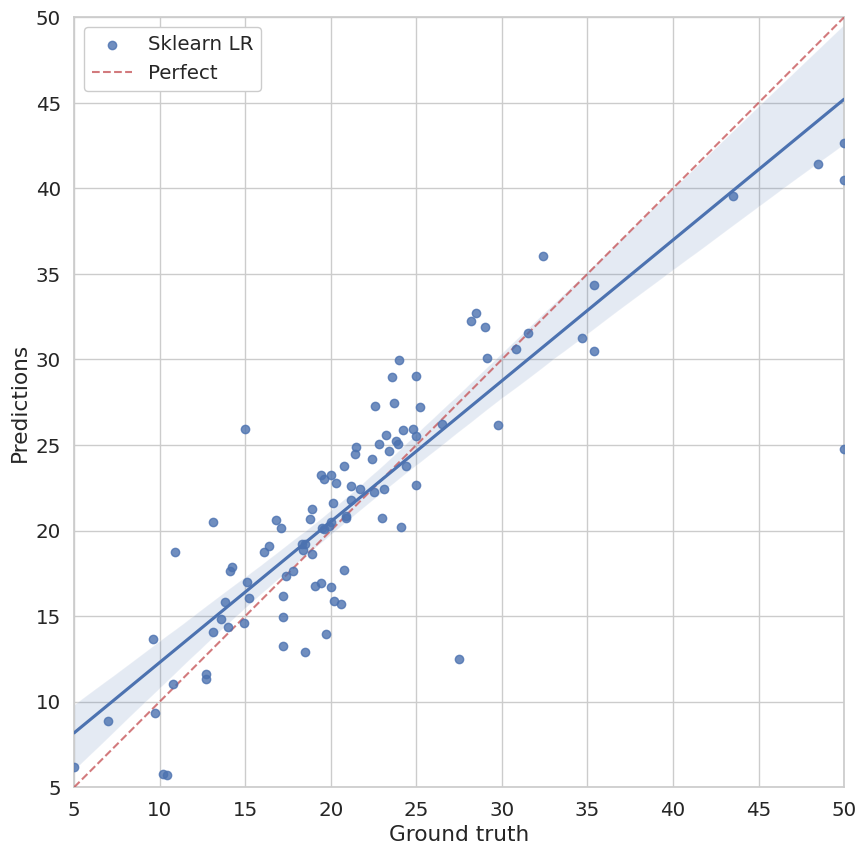

In [ ]:
draw_predictions(
    y_true=y_val,
    y_pred=model_lr_sklearn.predict(X_val_scaled),
    model_name="Sklearn LR",
)

## PyTorch

### Линейная регрессия

Модель "Линейная регрессия" можно рассматривать как простую нейронную сеть без скрытых слоев и без функций активации

Количество признаков в датасете Boston House Prices 13. Поэтому входной слой имеет 13 нейронов. Предсказывать мы хотим только одно значение - цену квартиры. Поэтому выходной слой имеет только один нейрон.

In [ ]:
model_lr = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=1),
)

Линейная регрессия - одна из немногих моделей, оптимальные веса для которой найти можно точно (с помощью конкретной формулы). Ровно это и было сделано в предыдущем разделе с помощью Sklearn.

Теперь же мы хотим обучать нейронную сеть, поэтому будем использовать простейший градиентный метод пошаговой оптимизации - Batch Gradient Descent.

In [ ]:
opt_lr = optim.SGD(params=model_lr.parameters(), lr=0.001)
batch_size_lr = 16

Тренируем модель

In [ ]:
%%time

epochs_lr = 1000
history_lr_train = []
history_lr_val = []

for epoch in tqdm(range(epochs_lr)):
    for i in range((n_data - 1) // batch_size_lr + 1):

        # формирование батча данных
        start_i = i * batch_size_lr
        end_i = start_i + batch_size_lr
        Xb = X_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]

        # forward pass: делаем предсказания
        pred = model_lr(Xb)
        # forward pass: считаем ошибку
        loss = loss_func(pred, yb)

        # backward pass: считаем градиенты
        loss.backward()

        # обновление весов
        opt_lr.step()
        opt_lr.zero_grad()

    history_lr_train.append(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor))
    history_lr_val.append(evaluate(model_lr, metrics_func, X_val_tensor, y_val_tensor))

history_lr_train = np.array(history_lr_train)
history_lr_val = np.array(history_lr_val)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 9.17 s, sys: 56.5 ms, total: 9.22 s
Wall time: 9.63 s


Нарисуем как менялась функция ошибки по ходу обучения

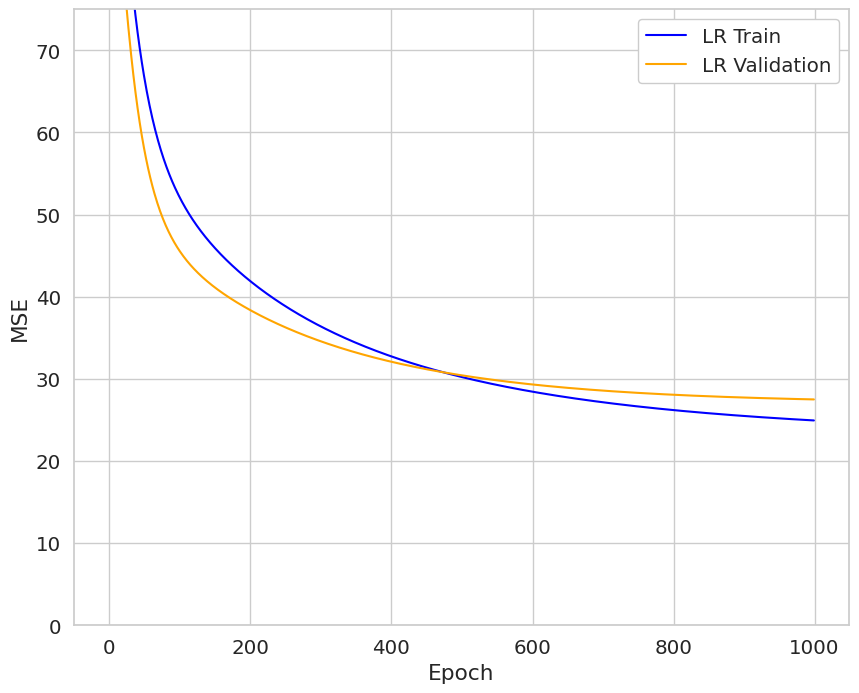

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_val[:, 0], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 75])
plt.ylabel("MSE")
plt.xlabel("Epoch");

In [ ]:
print_metrics(models=[model_lr_sklearn.predict, model_lr],
              metrics_func=metrics_func,
              train_data=(X_train_tensor, y_train_tensor),
              val_data=(X_val_tensor, y_val_tensor),
              metrics_name=["MSE", "MAPE"],
              models_name=["Sk LR", "LR"])

,MSE,MAPE
Sk LR Train,21.641413,16.574915
Sk LR Validation,24.291121,16.866394
LR Train,24.936108,17.028719
LR Validation,27.495922,17.666035


Пример предсказания

In [ ]:
X_val.tail(1)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
75,0.09512,0.0,12.83,0,0.437,6.286,45.0,4.5026,5,398,18.7,383.23,8.94


In [ ]:
y_val.tail(1)

75    21.4
Name: medv, dtype: float64

In [ ]:
with torch.no_grad():
    print(model_lr(X_val_tensor[-1:]))

tensor([[23.2577]])


In [ ]:
X_val_tensor[12]

torch.Size([13])

In [ ]:
x_t = torch.Tensor([0.5141, 0.0000, 0.6430, 0.0000, 0.6337, 0.1334, 1.0000, 0.0481, 1.0000,
        0.9141, 0.8085, 0.2218, 0.9727])
with torch.no_grad():
  print(model_lr(x_t))

tensor([-3.0605])


Нарисуем предсказания

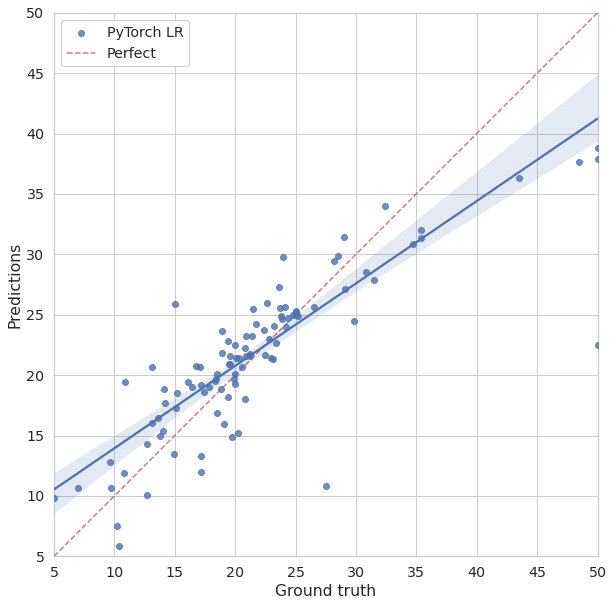

In [ ]:
with torch.no_grad():
    draw_predictions(
        y_true=y_val,
        y_pred=np.array(model_lr(X_val_tensor)).flatten(),
        model_name="PyTorch LR",
    )

### MLP с 3 скрытыми слоями

Теперь давайте определим более сложную модель с 3 скрытыми слоями и ReLU функцией активации.

![relu image](https://analyticsindiamag.com/wp-content/uploads/2018/01/relu-activation-function-1.png)

In [ ]:
model_mlp_3 = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=1)
)

Сеттинг для обучения почти такой же за исключением learning rate. Теперь мы сделаем его меньше, чтобы учесть более сложное пространство весов, которое легче проходить более маленькими шажками.

In [ ]:
opt_mlp_3 = optim.SGD(params=model_mlp_3.parameters(), lr=0.0001)
batch_size_mlp_3 = 16

Тренируем модель

In [ ]:
%%time

epochs_mlp_3 = 1000
history_mlp_3_train = []
history_mlp_3_val = []

for epoch in tqdm(range(epochs_mlp_3)):
    for i in range((n_data - 1) // batch_size_mlp_3 + 1):
        start_i = i * batch_size_mlp_3
        end_i = start_i + batch_size_mlp_3
        Xb = X_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]
        pred = model_mlp_3(Xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt_mlp_3.step()
        opt_mlp_3.zero_grad()

    history_mlp_3_train.append(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor))
    history_mlp_3_val.append(evaluate(model_mlp_3, metrics_func, X_val_tensor, y_val_tensor))

history_mlp_3_train = np.array(history_mlp_3_train)
history_mlp_3_val = np.array(history_mlp_3_val)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 12.2 s, sys: 71.9 ms, total: 12.3 s
Wall time: 12.5 s


Нарисуем как менялась функция ошибки по ходу обучения и сравним это с предыдущей моделью (PyTorch Linear Regression)

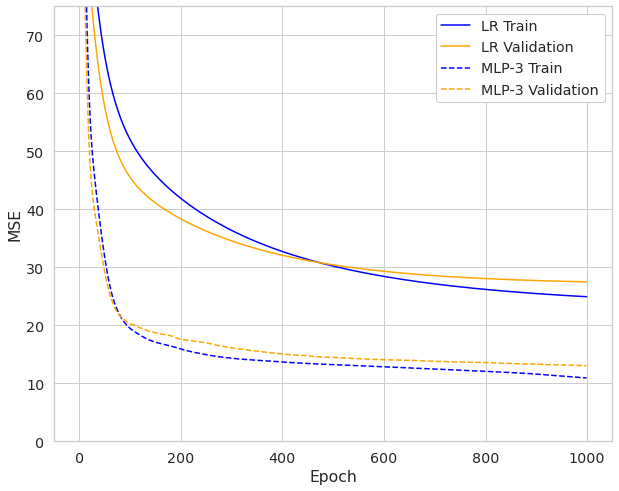

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_val[:, 0], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 0], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_val[:, 0], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 75])
plt.ylabel("MSE")
plt.xlabel("Epoch");

In [ ]:
print_metrics(models=[model_lr_sklearn.predict, model_lr, model_mlp_3],
              metrics_func=metrics_func,
              train_data=(X_train_tensor, y_train_tensor),
              val_data=(X_val_tensor, y_val_tensor),
              metrics_name=["MSE", "MAPE"],
              models_name=["Sk LR", "LR", "MLP-3"])

,MSE,MAPE
Sk LR Train,21.641413,16.574915
Sk LR Validation,24.291121,16.866394
LR Train,24.936108,17.028719
LR Validation,27.495924,17.666035
MLP-3 Train,10.916928,11.201792
MLP-3 Validation,13.020343,12.365133


Пример предсказания

In [ ]:
X_val.tail(1)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
75,0.09512,0.0,12.83,0,0.437,6.286,45.0,4.5026,5,398,18.7,383.23,8.94


In [ ]:
y_val.tail(1)

75    21.4
Name: medv, dtype: float64

In [ ]:
with torch.no_grad():
    print(model_mlp_3(X_val_tensor[-1:]))

tensor([[22.0474]])


Нарисуем предсказания

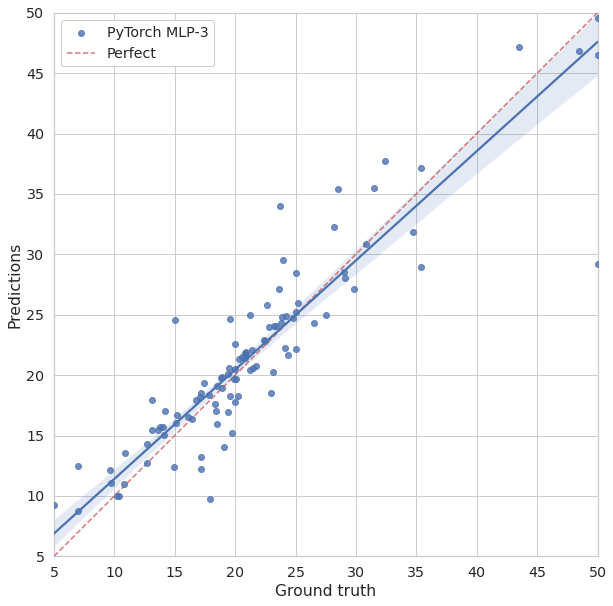

In [ ]:
with torch.no_grad():
    draw_predictions(
        y_true=y_val,
        y_pred=np.array(model_mlp_3(X_val_tensor)).flatten(),
        model_name="PyTorch MLP-3",
    )

Сохраним модель для последующего использования

Мы также можем послойно визуализировать получившуюся модель с помощью Netron

https://github.com/lutzroeder/netron

In [ ]:
torch.save(model_mlp_3, "mlp3.pth")